In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from carla_gym.core.obs_manager.birdview.Gaze import GazeDirection
import re
import seaborn as sns

import carla
import yaml
import os

from utils.server_utils import CarlaServerManager

In [2]:
def create_recording_field(csv_path):
    recording_path = csv_path.replace('diagnostics', 'recordings').rsplit('.', 1)[0] + '.log'
    recording_path = recording_path.replace(recording_path.split('/')[-1].split('_')[0], 'recording')
    return recording_path

def get_ep_stat_buffer_list(file_path, ep_stat_buffers):
    data = []
    n_stat_buffers = len(ep_stat_buffers)
    for i in range(n_stat_buffers):
        episodes = ep_stat_buffers[i]
        with open(os.path.join(file_path, episodes)) as f:
            json_files = json.load(f)
            json_lists = json_files['hero']
            for json_file in json_lists:
                # json_file['env_id'] = i
                # json_file['recording'] = create_recording_field(json_file['csv'])
                data.append(json_file)
    return data

def get_json(file_path, episode_id, data):
    episode = episode_id
    episode_data = data[episode]
    json_path = episode_data['json']
    json_path = os.path.join(file_path, json_path)
    with open(json_path, 'r') as f:
        episode_json_data = json.load(f)
        episode_json = episode_json_data['hero']
    return episode_json

def get_csv(file_path, episode_id, data):
    episode = episode_id
    episode_data = data[episode]
    csv_path = episode_data['csv']
    csv_path = os.path.join(file_path, csv_path)
    episode_csv = pd.read_csv(csv_path)
    return episode_csv

def create_accident_df_for_vehicles(file_path,episode_stat_dicts):
    ret_df = pd.DataFrame()
    n_episode = len(episode_stat_dicts)
    n_accidents = 0
    for i in range(n_episode):
        episode_json = get_json(file_path, i, episode_stat_dicts)
        vehicle_collision_dict = get_vehicle_collision_dict(episode_json)
        n_collision = len(vehicle_collision_dict)
        n_accidents += n_collision
        for j in range(n_collision):
            collision_info = vehicle_collision_dict[j]
            collision_info['env_id'] = episode_stat_dicts[i]['env_id']
            collision_info['accident_id'] = j
            for key in ['normal_impulse', 'event_loc', 'event_rot', 'ev_loc', 'ev_rot', 'ev_vel', 'oa_loc', 'oa_rot', 'oa_vel']:
                collision_info[f"{key}_x"], collision_info[f"{key}_y"], collision_info[f"{key}_z"] = collision_info.pop(key)
            ret_df = pd.concat([ret_df, pd.DataFrame([collision_info])], ignore_index=True)
    return ret_df
    
def get_vehicle_collision_dict(episode_json):
    vehicle_collision_dict = {}
    for i in range(len(episode_json['collisions_vehicle'])):
        vehicle_collision_dict[i] = episode_json['collisions_vehicle'][i]
    return vehicle_collision_dict

def get_vehicle_collision_simulation_frame(episode_json):
    vehicle_collision_simulation_frame = []
    for i in range(len(episode_json['collisions_vehicle'])):
        vehicle_collision_simulation_frame.append(episode_json['collisions_vehicle'][i]['step'])
    return vehicle_collision_simulation_frame

# Define a function to extract the step value using regular expressions
def extract_step(s):
    match = re.search(r"'step': (\d+)", s)
    if match:
        return int(match.group(1))
    else:
        return pd.NA

def get_filtered_df_for_collision_with_vehicle(episode_number, threshold, accident_id, data_dict):
    # Assuming get_json and get_csv are defined elsewhere and load episode data
    episode_json = get_json(file_path, episode_number, data_dict)
    episode_csv = get_csv(file_path, episode_number, data_dict)
    
    # Extracting vehicle collision steps
    collisions_vehicle_sim_step = get_vehicle_collision_simulation_frame(episode_json)
    
    # Assuming accident_id corresponds to an index in collisions_vehicle_sim_step
    if accident_id < len(collisions_vehicle_sim_step):
        accident_step = collisions_vehicle_sim_step[accident_id]
    else:
        raise ValueError('accident_id is out of bounds')
    
    # Extract step from timestamp
    episode_csv['step'] = episode_csv['timestamp'].apply(extract_step)
    episode_csv.drop(['timestamp', 'frame'], axis=1, inplace=True)
    
    # Filter based on threshold around the accident step
    start_step = accident_step - threshold
    end_step = accident_step + threshold
    filtered_df = episode_csv[(episode_csv['step'] >= start_step) & (episode_csv['step'] <= end_step)]
    
    return filtered_df[['step', 'gaze_direction', 'perception_error']]

#Visualization

In [3]:
def plot_data_table(df):
    
    # Change the data types
    df['encounter_light'] = df['encounter_light'].astype(int)
    df['encounter_stop'] = df['encounter_stop'].astype(int)
    df['is_route_completed'] = df['is_route_completed'].astype(bool)
    df['is_route_completed_nocrash'] = df['is_route_completed_nocrash'].astype(bool)
    df['light_passed'] = df['light_passed'].astype(int)
    df['red_light'] = df['red_light'].astype(int)
    df = df.round(2)
    df = df.T
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.axis('off')
    ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')
    plt.show()

def show_gaze_distribution(episode_csv):
    episode_csv['gaze_direction'].value_counts().plot(kind='bar')
    plt.xlabel('Gaze Direction')
    plt.ylabel('Frequency')
    plt.title('Gaze Direction Frequency')
    plt.show()
    
def plot_step_vs_gaze_direction(episode, threshold, accident_id, data_dict):
    filtered_df = get_filtered_df_for_collision_with_vehicle(episode_number=episode,
                                  threshold=threshold, 
                                  accident_id=accident_id, 
                                  data_dict=data_dict)

    # Plotting, assuming filtered_df is the returned DataFrame
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(10, 5))
    sns.lineplot(x='step', y='gaze_direction', data=filtered_df, marker='o', label='Gaze Direction')
    median_step = filtered_df['step'].median()
    plt.axvline(x=median_step, color='r', linestyle='--', label='Median Step')
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.title('Step vs Gaze Direction')
    plt.legend()
    plt.show()
    pass

def plot_step_vs_perception_error(episode, threshold, accident_id, data_dict):
    filtered_df = get_filtered_df_for_collision_with_vehicle(episode_number=episode,
                                  threshold=threshold, 
                                  accident_id=accident_id, 
                                  data_dict=data_dict)

    # Plotting, assuming filtered_df is the returned DataFrame
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(10, 5))
    sns.lineplot(x='step', y='perception_error', data=filtered_df, marker='x', label='Perception Error')
    median_step = filtered_df['step'].median()
    plt.axvline(x=median_step, color='r', linestyle='--', label='Median Step')
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.title('Step vs Perception Error')
    plt.legend()
    plt.show()
    pass

In [7]:
# C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-04\16-20-45
file_path = r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-04\23-08-53'
diagnostics = os.path.join(file_path, 'diagnostics')
# find all files with name ep_stat_buffer in the folder
ep_stat_buffers = [f for f in os.listdir(file_path) if 'ep_stat_buffer' in f]
print(ep_stat_buffers)

['ep_stat_buffer_0.json']


12


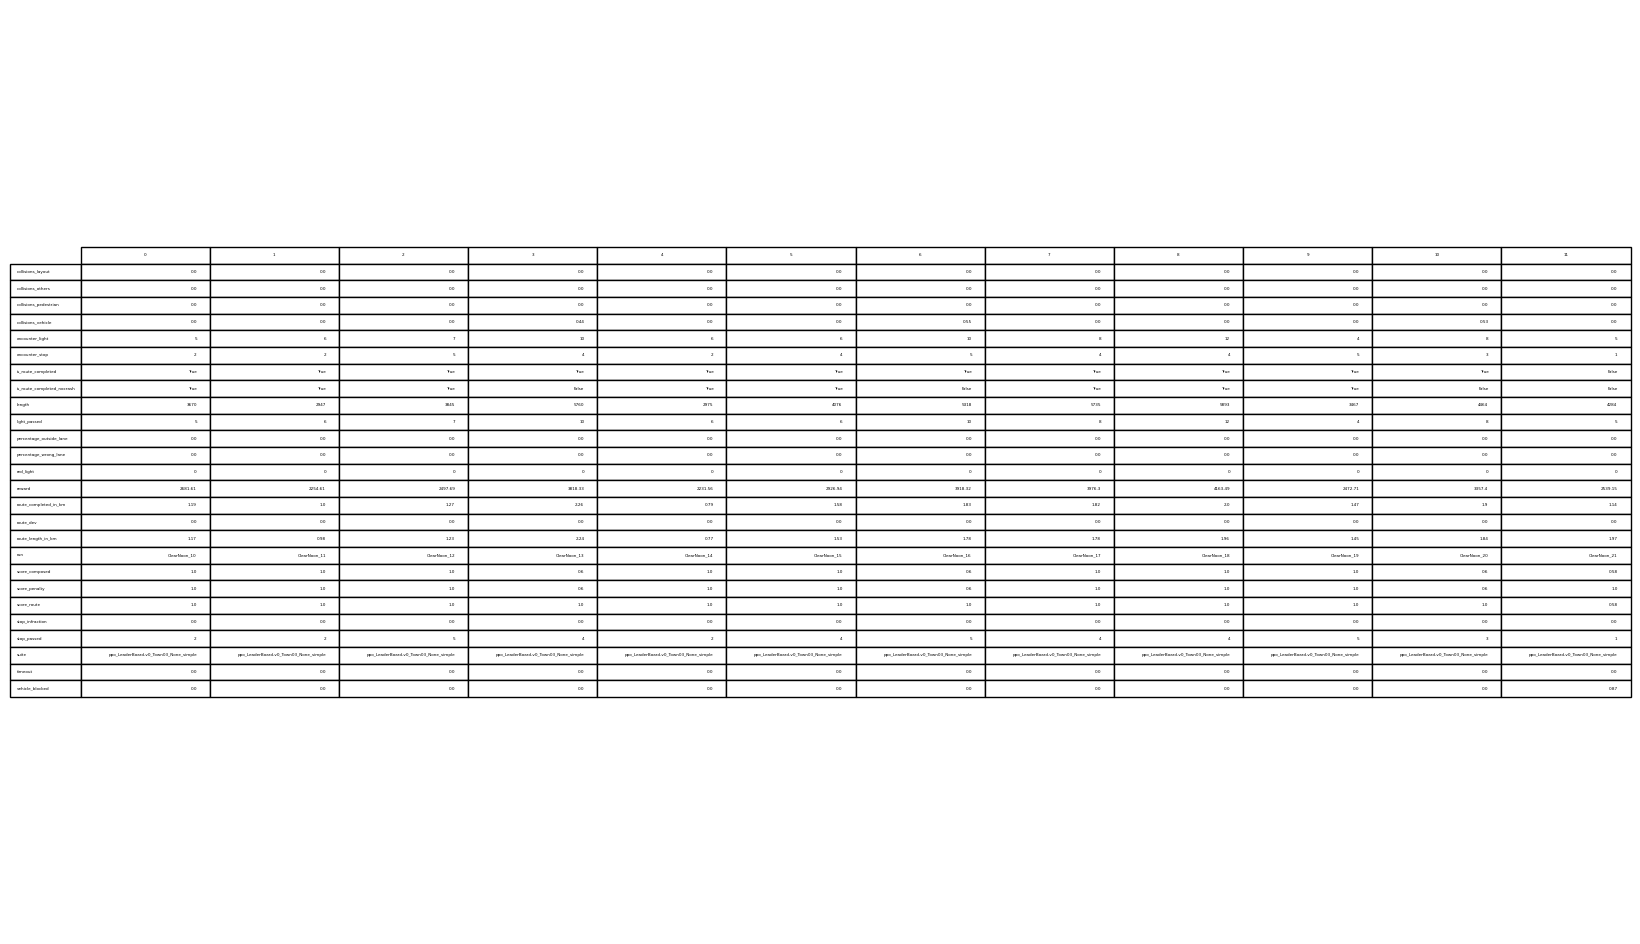

In [8]:
episode_stat_dicts = get_ep_stat_buffer_list(file_path, ep_stat_buffers)
episode_stat_df = pd.DataFrame(episode_stat_dicts)
print(len(episode_stat_dicts))
# for stat_dict in episode_stat_dicts:
#     print(stat_dict)
plot_data_table(episode_stat_df)

In [6]:
accident_df = create_accident_df_for_vehicles(file_path, episode_stat_dicts)
accident_df.columns

KeyError: 'env_id'

In [ ]:
# episode = 7
# accident_id = 0
# threshold = 50
# episode_json = get_json(file_path, episode, episode_stat_dicts)
# episode_csv = get_csv(file_path, episode, episode_stat_dicts)

# # plot_step_vs_gaze_direction(episode, threshold, accident_id, episode_stat_dicts)
# # plot_step_vs_perception_error(episode, threshold, accident_id, episode_stat_dicts)


In [ ]:
import numpy as np
import pandas as pd



def determine_accident_type(row):
    # Helper functions for vector operations
    def vector_from_row(row, prefix):
        return np.array([row[f'{prefix}_x'], row[f'{prefix}_y'], row[f'{prefix}_z']])
    
    def unit_vector(vector):
        return vector / np.linalg.norm(vector)
    
    def angle_between(v1, v2):
        v1_u = unit_vector(v1)
        v2_u = unit_vector(v2)
        radians = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
        degrees = np.degrees(radians)
        return degrees

    # Extract relevant vectors from the row
    ev_loc = vector_from_row(row, 'ev_loc')
    oa_loc = vector_from_row(row, 'oa_loc')

    ev_vel = vector_from_row(row, 'ev_vel')
    oa_vel = vector_from_row(row, 'oa_vel')

    ev_rot = vector_from_row(row, 'ev_rot')
    oa_rot = vector_from_row(row, 'oa_rot')

    normal_impulse = vector_from_row(row, 'normal_impulse')
    
    # Calculate the angle between the velocity vectors
    angle_vel = angle_between(ev_vel, oa_vel)
    angle_rot = angle_between(ev_rot, oa_rot)

    distance = np.linalg.norm(ev_loc - oa_loc)
    
    # Determine the direction of the relative velocity and the normal impulse
    relative_velocity_direction = unit_vector(ev_vel - oa_vel)
    normal_impulse_direction = unit_vector(normal_impulse)
    
    # Calculate the angle between the relative velocity direction and the normal impulse direction
    angle = angle_between(relative_velocity_direction, normal_impulse_direction)
    
    print(f"Distance between vehicles: {distance}")
    print(f"Angle between velocity vectors: {angle_vel}")
    print(f"Angle between rotation vectors: {angle_rot}")
    print(f"Relative velocity direction: {relative_velocity_direction}")
    print(f"Normal impulse direction: {normal_impulse_direction}")
    print(f"Angle between relative velocity and normal impulse: {angle}")
    # Accident type determination logic based on the angle
    if angle < np.pi / 6:
        return "Rear-end or Head-on"
    elif angle > 5 * np.pi / 6:
        return "Side-swipe"
    else:
        return "Angle"

index = 0
row = accident_df.loc[index]
accident_type = determine_accident_type(row)
print(f"env {row['env_id']} Accident ID {row['accident_id']} sim time {row['simulation_time']} is a {accident_type} collision.")




In [ ]:
# def determine_accident_type(row):
#     # Helper functions for vector operations
#     def vector_from_row(row, prefix):
#         return np.array([row[f'{prefix}_x'], row[f'{prefix}_y'], row[f'{prefix}_z']])
    
#     def unit_vector(vector):
#         return vector / np.linalg.norm(vector)
    
#     def angle_between(v1, v2):
#         v1_u = unit_vector(v1)
#         v2_u = unit_vector(v2)
#         return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

#     # Extract relevant vectors from the row
#     ev_vel = vector_from_row(row, 'ev_vel')
#     oa_vel = vector_from_row(row, 'oa_vel')
#     normal_impulse = vector_from_row(row, 'normal_impulse')
    
#     # Determine the direction of the relative velocity and the normal impulse
#     relative_velocity_direction = unit_vector(ev_vel - oa_vel)
#     normal_impulse_direction = unit_vector(normal_impulse)
    
#     # Calculate the angle between the relative velocity direction and the normal impulse direction
#     angle = angle_between(relative_velocity_direction, normal_impulse_direction)
    
#     # Accident type determination logic based on the angle
#     if angle < np.pi / 6:
#         return "Rear-end or Head-on"
#     elif angle > 5 * np.pi / 6:
#         return "Side-swipe"
#     else:
#         return "Angle"